In [7]:
# https://keras.io/
# !pip install -q keras
import keras

In [8]:
import os
os.getcwd()

'/media/sukant/Moz/DS/DL/CIFAR10'

In [9]:
import keras
import numpy as np
import pickle
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory backend
import tensorflow as tf
from keras import backend as K

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [12]:
num_classes = 10
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 90s 1us/step


In [13]:
# standardizing the images
x_train_mean = x_train.mean(axis =0)
x_train_std = x_train.std(axis=0)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

In [14]:
x_train_mean.shape, x_train_std.shape

((32, 32, 3), (32, 32, 3))

In [23]:
# saving the standardizing arrays to standardize any test image further
with open("standardizing_arrays.pkl", 'wb') as f:
    pickle.dump([x_train_mean, x_train_std], file=f)

In [0]:
# Hyperparameters
batch_size = 64
l = 16
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [0]:
# convolution
def conv_layer(input, num_filter, dropout_rate, l2_reg, kernel_size =3):
  BatchNorm = BatchNormalization(gamma_regularizer=l2(l2_reg), beta_regularizer=l2(l2_reg))(input)
  relu = Activation('relu')(BatchNorm)
  conv = Conv2D(num_filter, kernel_size, padding = 'same', kernel_regularizer = l2(l2_reg), use_bias = False)(relu)
  if dropout_rate>0:
    conv = Dropout(dropout_rate)(conv)
  return conv

In [0]:
# bottleneck layer
def bottleneck_layer(input, num_filter, dropout_rate, l2_reg, kernel_size=3):
  conv1 = conv_layer(input, num_filter*4, dropout_rate, l2_reg, kernel_size=1)
  conv3 = conv_layer(conv1, num_filter, dropout_rate, l2_reg, kernel_size=kernel_size)
  return conv3

In [0]:
# Dense Block
def add_denseblock(input, num_filter, dropout_rate, l2_reg, bottleneck=False, kernel_size=3):
    temp = input
    for _ in range(l):
        if bottleneck:
          output = bottleneck_layer(temp, num_filter, dropout_rate, l2_reg, kernel_size=kernel_size)
        else:
          output = conv_layer(temp, num_filter, dropout_rate, l2_reg, kernel_size=3)
    
        concat = Concatenate(axis=-1)([temp,output])
        temp = concat
        
    return temp

In [0]:
# Transition Block
def add_transition(input, num_filter, dropout_rate, l2_reg):
    output = conv_layer(input, num_filter, dropout_rate, l2_reg, kernel_size=1)
    avg = AveragePooling2D(pool_size=(2,2))(output)
    return avg

In [0]:
# Output layer
def output_layer(input, l2_reg):
    BatchNorm = BatchNormalization(gamma_regularizer=l2(l2_reg), beta_regularizer=l2(l2_reg))(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
num_blocks = 3
num_channels = 32
l2_reg = 1e-4
input = Input(shape=(img_height, img_width, channel,))
out = Conv2D(num_channels, (3,3), use_bias=False, kernel_regularizer = l2(l2_reg), padding='same')(input)

for i in range(num_blocks-1):
  out = add_denseblock(out, num_filter=num_filter, dropout_rate=dropout_rate, l2_reg= l2_reg, bottleneck=True)
  num_channels += l*num_filter
  num_channels = int(num_channels*compression)
  out = add_transition(out, num_filter=num_channels, dropout_rate=dropout_rate, l2_reg= l2_reg)

out = add_denseblock(out, num_filter=num_filter, dropout_rate=dropout_rate, l2_reg= l2_reg, bottleneck=True)

output = output_layer(out, l2_reg = 1e-4,)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras import optimizers
from keras import callbacks

In [0]:
# Scheduling the learning rate to decrease by 0.1 after 50% of epochs and 75% of epochs
from keras import backend as K
def scheduler(epoch):
  if epoch > 125 and epoch <= 188:
    K.set_value(model.optimizer.lr, 0.01)
  elif epoch >188:
    K.set_value(model.optimizer.lr, 0.001)
  return K.get_value(model.optimizer.lr)

change_lr = callbacks.LearningRateScheduler(scheduler)

In [0]:
# Creating checkpoints to save weights after every 10 epochs which will be saved only if the current epoch's validation accuracy is better than the last saved one
checkpointer = callbacks.ModelCheckpoint(filepath= 'DNST_Final_{epoch:02d}-{val_loss:.2f}.hdf5', 
                                         monitor = 'val_acc',
                                         mode = 'max',
                                         save_best_only = True,
                                         save_weights_only=True,
                                         period =10)

In [0]:
sgd = optimizers.SGD(lr = 0.1, decay = 1e-6, momentum=0.9, nesterov=True )

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
# Augmenting the images
data_gen = ImageDataGenerator(horizontal_flip=True,
                              rotation_range = 15,
                              width_shift_range=0.125,
                              height_shift_range=0.125,
                              fill_mode='nearest')

data_iter = data_gen.flow(x_train, y_train, batch_size=64, shuffle=True)

model.fit_generator(data_iter,
                    samples_per_epoch=60000,
                    steps_per_epoch=len(x_train)/64,
                    epochs=250,
                    verbose = 1,
                    validation_data=(x_test,y_test),
                    callbacks=[change_lr, checkpointer])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=937, callbacks=[<keras.ca..., verbose=1, validation_data=(array([[[..., epochs=250)`
  from ipykernel import kernelapp as app


Epoch 1/250
937/937 [==============================] - 210s 224ms/step - loss: 4.5757 - acc: 0.2810 - val_loss: 3.8231 - val_acc: 0.3775
Epoch 2/250
937/937 [==============================] - 173s 185ms/step - loss: 3.5377 - acc: 0.3752 - val_loss: 3.2719 - val_acc: 0.3546
Epoch 3/250
937/937 [==============================] - 174s 186ms/step - loss: 2.7819 - acc: 0.4335 - val_loss: 2.4716 - val_acc: 0.4714
Epoch 4/250
937/937 [==============================] - 173s 185ms/step - loss: 2.2963 - acc: 0.4807 - val_loss: 1.9822 - val_acc: 0.5462
Epoch 5/250
937/937 [==============================] - 174s 186ms/step - loss: 1.9497 - acc: 0.5167 - val_loss: 1.7685 - val_acc: 0.5660
Epoch 6/250
937/937 [==============================] - 173s 185ms/step - loss: 1.7064 - acc: 0.5492 - val_loss: 1.5612 - val_acc: 0.5771
Epoch 7/250
937/937 [==============================] - 175s 186ms/step - loss: 1.5124 - acc: 0.5842 - val_loss: 1.7801 - val_acc: 0.5689
Epoch 8/250
937/937 [====================

In the above training output, the jupyter lab was not responding, so, you don't see the output for all the logs, but, the model was running on the server. Below, I have plotted the validation accuracy and training accuracy to get the overall picture. I have also saved the history in a pandas dataframe to show the model accuracy for all the epochs. Also, I have trained the model for last 50 epochs of the 250 epochs without augmenting the images where you get to see the logs for the last 50 epochs.   

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 10s 1ms/step
Test loss: 0.41322941830158233
Test accuracy: 0.9203


So, training the dataset with augmentation crosses the benchmark of 92%. Infact, at epoch number 222, the model attains validation accuracy of 92.39%. 

In [0]:
# Save the trained weights in to .h5 format
model.save("DNST_Final_Aug_epochs_250.h5")
print("Saved model to disk")

Saved model to disk


Storing model logs in a pandas dataframe and printing the logs below. 

In [0]:
import pandas as pd
pd.options.display.max_rows = 250
log_df = pd.DataFrame(model.history.history)

In [0]:
log_df

,acc,loss,lr,val_acc,val_loss
0,0.281158,4.574391,0.100,0.3775,3.823143
1,0.375167,3.537856,0.100,0.3546,3.271892
2,0.433545,2.781619,0.100,0.4714,2.471615
3,0.480658,2.295935,0.100,0.5462,1.982199
4,0.516689,1.949557,0.100,0.5660,1.768489
5,0.549121,1.706527,0.100,0.5771,1.561244
6,0.584296,1.512141,0.100,0.5689,1.780126
7,0.614853,1.368749,0.100,0.5715,1.671411
8,0.648114,1.243418,0.100,0.6713,1.203994
9,0.666088,1.165405,0.100,0.6505,1.334243


Plotting the accuracy and loss gives a better picture of the model training.  

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

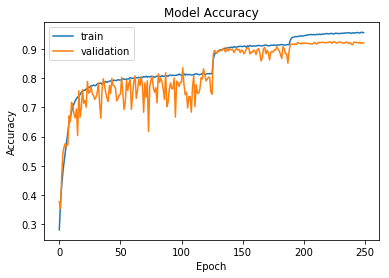

In [0]:
plt.plot(log_df['acc'])
plt.plot(log_df['val_acc'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'validation'], loc='upper_left')
plt.show()

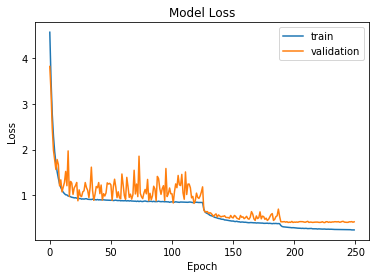

In [0]:
plt.plot(log_df['loss'])
plt.plot(log_df['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train', 'validation'], loc='upper_left')
plt.show()

Now, we will try to learn the weights without augmenting the images when we decrease the learning from 0.01 to 0.001. Since, we were saving the best model weights after every 10 epochs, we have weights available for the 200th epoch. So, we will load those weights and train the model from 200th epoch onwards without augmenting the images for 50 more epochs and see the result. So, technically, we will be training for 250 epochs only. 

In [0]:
model.load_weights("DNST_Final_200-0.40.hdf5")

In [0]:
sgd = optimizers.SGD(lr = 0.001, decay = 1e-6, momentum=0.9, nesterov=True )

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
checkpointer_50 = callbacks.ModelCheckpoint(filepath= 'DNST_Final_No_Aug_Last50_{epoch:02d}-{val_loss:.2f}.hdf5', 
                                         monitor = 'val_acc',
                                         mode = 'max',
                                         save_best_only = True,
                                         save_weights_only=True,
                                         period =10)

In [0]:
model.fit(x_train, y_train,
          epochs =50,
          batch_size = 64,
          verbose = 1,
          validation_data = [x_test, y_test],
          callbacks=[checkpointer_50])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 173s 3ms/step - loss: 0.2291 - acc: 0.9633 - val_loss: 0.3450 - val_acc: 0.9320
Epoch 2/50
50000/50000 [==============================] - 148s 3ms/step - loss: 0.2228 - acc: 0.9667 - val_loss: 0.3511 - val_acc: 0.9310
Epoch 3/50
50000/50000 [==============================] - 147s 3ms/step - loss: 0.2172 - acc: 0.9681 - val_loss: 0.3467 - val_acc: 0.9323
Epoch 4/50
50000/50000 [==============================] - 147s 3ms/step - loss: 0.2157 - acc: 0.9682 - val_loss: 0.3471 - val_acc: 0.9330
Epoch 5/50
50000/50000 [==============================] - 147s 3ms/step - loss: 0.2114 - acc: 0.9697 - val_loss: 0.3512 - val_acc: 0.9326
Epoch 6/50
50000/50000 [==============================] - 147s 3ms/step - loss: 0.2119 - acc: 0.9698 - val_loss: 0.3507 - val_acc: 0.9309
Epoch 7/50
50000/50000 [==============================] - 148s 3ms/step - loss: 0.2089 - acc: 0.9704 - val_loss: 0.3528 - 

In the above logs, we see that not augmenting for the last 50 epochs helped in achieving higher accuracy with 93.57 as the highest accuracy at 210th (or 10th epoch in the above output) epoch. 

In [0]:
better_score = model.evaluate(x_test, y_test, verbose = 1, batch_size=64)
print("test loss:", better_score[0])
print("test accuracy:", better_score[1])

10000/10000 [==============================] - 8s 770us/step
test loss: 0.38449104194641115
test accuracy: 0.9323


In [0]:
# Save the trained weights in to .h5 format
model.save("DNST_Final_No_Aug_Last50.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# saving the logs to pandas dataframe
better_log_df = pd.DataFrame(model.history.history)
better_log_df.head()

,acc,loss,val_acc,val_loss
0,0.96330,0.229079,0.9320,0.345002
1,0.96668,0.222764,0.9310,0.351142
2,0.96810,0.217228,0.9323,0.346746
3,0.96816,0.215706,0.9330,0.347083
4,0.96974,0.211427,0.9326,0.351246


In [0]:
# concatenating the output from first 200 epochs with last 50 epochs done above
better_log_df =  pd.concat([log_df.iloc[0:200,[0,1,3,4]], better_log_df], axis=0, ignore_index = True)

In [0]:
better_log_df

,acc,loss,val_acc,val_loss
0,0.281158,4.574391,0.3775,3.823143
1,0.375167,3.537856,0.3546,3.271892
2,0.433545,2.781619,0.4714,2.471615
3,0.480658,2.295935,0.5462,1.982199
4,0.516689,1.949557,0.5660,1.768489
5,0.549121,1.706527,0.5771,1.561244
6,0.584296,1.512141,0.5689,1.780126
7,0.614853,1.368749,0.5715,1.671411
8,0.648114,1.243418,0.6713,1.203994
9,0.666088,1.165405,0.6505,1.334243


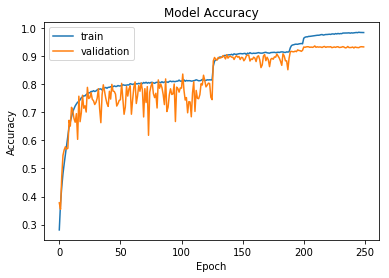

In [0]:
plt.plot(better_log_df['acc'])
plt.plot(better_log_df['val_acc'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'validation'])
plt.show()